# Rozpoznawanie akordów muzycznych z użyciem sieci konwolucyjnej

### Importowanie bibliotek

In [1]:
import os
import tensorflow as tf
import librosa as lb
import numpy
import seaborn as sns
import soundfile as sf
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten
from tensorflow.keras.layers import *
from tensorflow.keras import Input

### Definicja ścieżek do zbiorów danych

In [2]:
TEST_DIR = r"D:\PRZEDMIOTY\5 semestr\Sieci neuronowe\Projekt\data\Test"
TRAIN_DIR = r"D:\PRZEDMIOTY\5 semestr\Sieci neuronowe\Projekt\data\Training"

### Funkcja `loading` - wczytywanie plików audio
Ponizsza funkcja odpowiada za wczytanie pliku audio w formacie *.wav*, ujednolicenie częstotliwości próbkowania do 16kHz, konwersję sygnału do postaci mono oraz zamianę sygnału audio na tensor *TensorFlow*.

In [3]:
def loading(plik):
    wav, rate = lb.load(plik, sr=16000, mono=True)
    return tf.convert_to_tensor(wav, dtype=tf.float32)

### Wizualizacja przykładowych sygnałów audio dla poszczególnych akordów
Poniżej wyświetlone zostały przebiegi czasowe (*waveformy*) przykładowych nagrań dla każdego akordu, osobno dla zbioru treningowego (*Train*) oraz testowego (*Test*). Celem jest wizualna kontrola poprawności wczytania danych oraz porównanie sygnałów.

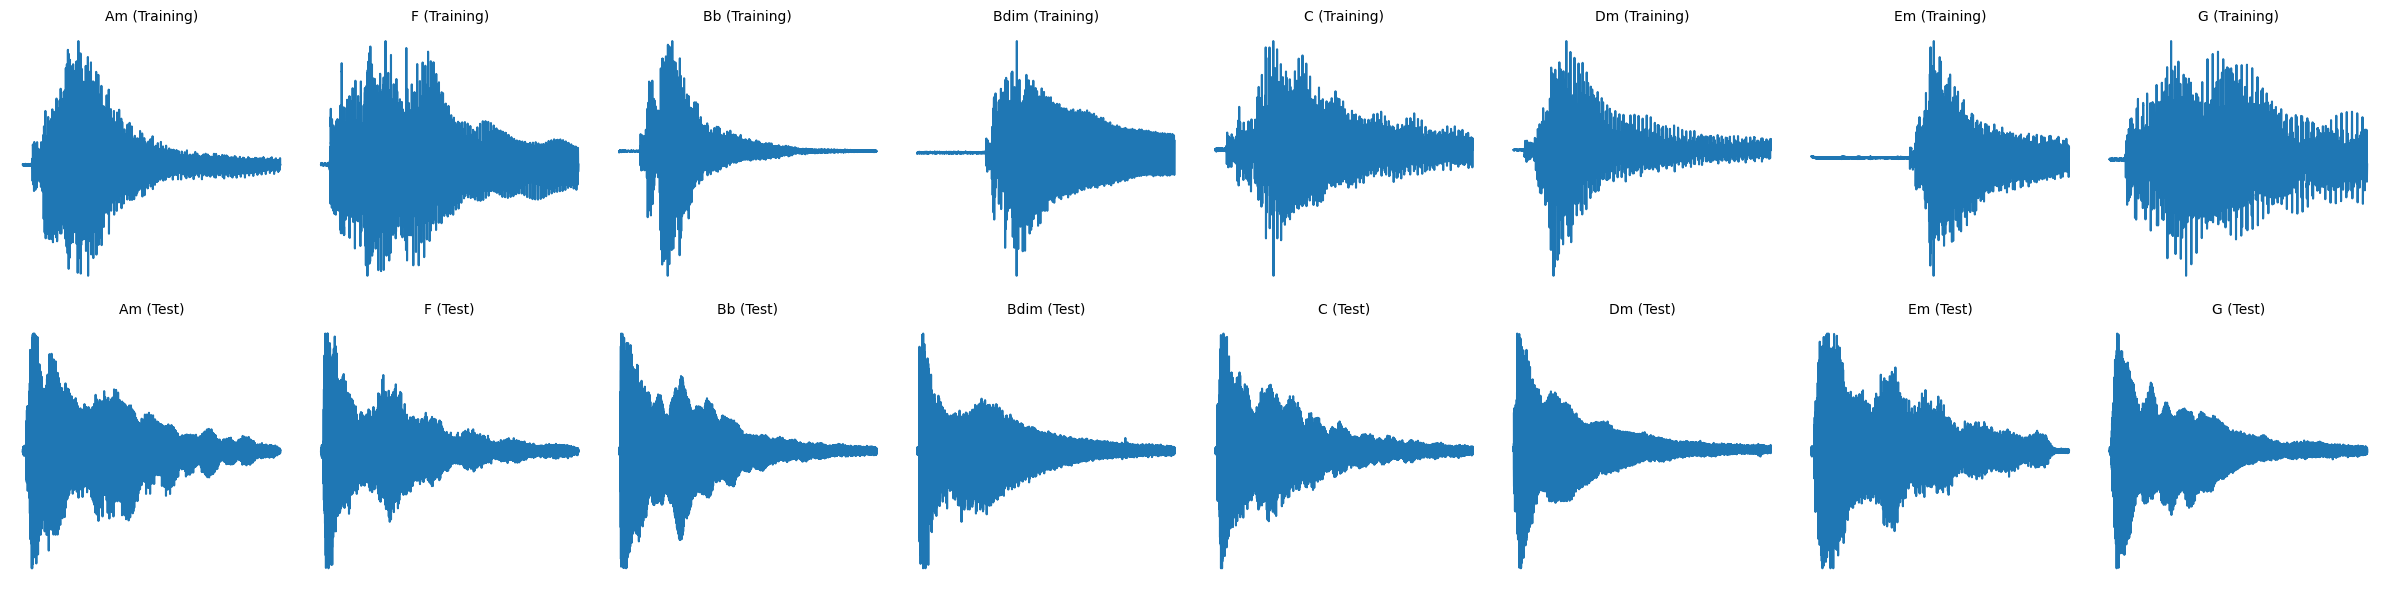

In [4]:
chords = ["Am", "F", "Bb", "Bdim", "C", "Dm", "Em", "G"]

fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(24, 6))
axes = axes.flatten()

i = 0
folders = [TRAIN_DIR, TEST_DIR]

for folder in folders:
    for chord in chords:
        chord_folder = os.path.join(folder, chord)
        files = [f for f in os.listdir(chord_folder) if f.endswith(".wav")]
        if not files:
            continue
        file_path = os.path.join(chord_folder, files[0])
        wave = loading(file_path)

        axes[i].plot(wave)
        axes[i].set_title(f"{chord} ({os.path.basename(folder)})", fontsize=10)
        axes[i].axis("off")
        i += 1

plt.tight_layout()
plt.show()

### Funkcja `buildSet` – budowa zbioru danych audio

Funkcja `buildSet` tworzy jeden wspólny zbiór danych zawierający pary:
- *ścieżka do pliku audio*,
- *etykieta akordu*.

Dane są zorganizowane w strukturze katalogów, w której każdy folder odpowiada
jednemu akordowi, a jego zawartość stanowią pliki audio reprezentujące ten akord.

Proces budowy zbioru danych przebiega następująco:
- każdemu akordowi przypisywana jest unikalna etykieta liczbowa,
- dla każdego akordu tworzony jest osobny, niewielki dataset,
- wszystkie datasety cząstkowe są następnie sekwencyjnie łączone
  w jeden wspólny zbiór danych.

In [5]:
def buildSet(dir):
    Akordy = {
        "Am": os.path.join(dir, "Am"),
        "F": os.path.join(dir, "F"),
        "Bb": os.path.join(dir, "Bb"),
        "Bdim": os.path.join(dir, "Bdim"),
        "C": os.path.join(dir, "C"),
        "Dm": os.path.join(dir, "Dm"),
        "Em": os.path.join(dir, "Em"),
        "G": os.path.join(dir, "G")
    }

    LABELS = {
        "Am": 0,
        "F": 1,
        "Bb": 2,
        "Bdim": 3,
        "C": 4,
        "Dm": 5,
        "Em": 6,
        "G": 7
    }

    labeled_datasets = []
    for chord, folder in Akordy.items(): # iterujemy po kazdym akordzie i jego folderze
        label = LABELS[chord] # pobieramy liczbe odpowiadajaca temu akordowi

        # tworzenie datasetu wszystkich sciezek do plikow .wav w danym folderze
        files_ds = tf.data.Dataset.list_files(
            os.path.join(folder, "*.wav"),
            shuffle=False # nie mieszaj kolejności plikow
        )

        labels_ds = files_ds.map(lambda x, l=label: l) # mapujemy pliki na etykiety
        
        # laczymy dwa datasety element po elemencie i dostajemy pary: sciezka do pliku , etykieta
        labeled_ds = tf.data.Dataset.zip((files_ds, labels_ds))
        
        labeled_datasets.append(labeled_ds) #dodajemy dataset  do listy


    # tworzenie jednego duzego datasetu dla wszystkich akordow
    data = labeled_datasets[0] # inicjalizacja wynikowego datasetu od pierwszego akordu
    for ds in labeled_datasets[1:]:
        data = data.concatenate(ds) # sekwencyjne łączenie pozostałych datasetów w jeden spójny zbiór danych
        
    return data

### Tworzenie treningowego i testowego zbioru danych

In [6]:
train_data = buildSet(TRAIN_DIR)
test_data = buildSet(TEST_DIR)

### Analiza długości nagrań w zbiorze treningowym
Dla każdego pliku audio w zbiorze `train_data` sprawdzamy jego długość w próbkach, a następnie obliczamy średnią, minimalną i maksymalną długość, zarówno w próbkach, jak i sekundach. 
Na tej podstawie możemy dobrać stałą długość wejścia (`TARGET_LEN`) dla modelu.

In [8]:
lengths = [] # lista dlugosci syngalow w probkach

for file_path, label in train_data: # iteracja po wszystkich elementach datasetu TRAIN
    wav = loading(file_path.numpy().decode()) # wczytanie pliku audio jako tensor (mono, 16kHz)
    lengths.append(len(wav)) # zapisanie długosci sygnalu w probkach

lengths = tf.constant(lengths) # dlugosci zmieniamy na tensor

sr = 16000 # częstotliwość próbkowania w Hz

# Obliczenie statystyk długości nagrań
mean_samples = tf.reduce_mean(lengths).numpy() # srednia dlugosc w probkach
min_samples = tf.reduce_min(lengths).numpy() # minimalna długosc
max_samples = tf.reduce_max(lengths).numpy() # maksymalna długosc

# przeliczenie na sekundy
mean_sec = mean_samples / sr
min_sec = min_samples / sr
max_sec = max_samples / sr

print(f"Mean: {mean_samples} próbek / {mean_sec:.2f} s")
print(f"Min: {min_samples} próbek / {min_sec:.2f} s")
print(f"Max: {max_samples} próbek / {max_sec:.2f} s")

Mean: 90326 próbek / 5.65 s
Min: 27600 próbek / 1.73 s
Max: 261502 próbek / 16.34 s


### *TARGET_LEN* - dobór docelowej długości nagrań audio dla modelu
Zmiennej *TARGET_LEN* przypisano średnią długość nagrań audio ze zbioru treningowego, co pozwoli ujednolicić sygnały i przygotować je do trenowania sieci neuronowej.

In [9]:
TARGET_LEN = mean_samples # dlugosc w probkach: 5.65s (srednia) przy 16KHz

### Funkcja `preprocess` - przygotowanie sygnału audio do modelu
Funkcja `preprocess`:
- wczytuje plik audio i przycina lub uzupełnia go zerami do *TARGET_LEN*,
- konwertuje sygnał do tensora *TensorFlow* typu *float32*,
- generuje spektogram za pomocą *Short-Time Fourier Transform (STFT)*,
- dodaje wymiar kanału, aby przygotować dane do wejścia w sieci konwolucyjne,
- zwraca parę *(spektogram, etykieta)*, gotową do dalszego przetwarzania i trenowania modelu.

In [10]:
def preprocess(file_path, label):  # zamiana (ścieżka, etykieta) → (spektrogram, etykieta)
    def _load(path): 
        wav, _ = lb.load(path.numpy().decode(), sr=16000, mono=True) # wczytuje plik .wav jako tablice probek audio (mono, 16 kHz)
        wav = wav[:TARGET_LEN] # jesli nagranie jest dluzsze niz TARGET_LEN, przycinamy do pierwszych TARGET_LEN probek
        if len(wav) < TARGET_LEN: # jesli nagranie jest krotsze niz TARGET_LEN
            wav = numpy.pad(
                wav,
                (0, TARGET_LEN - len(wav)) # dopelniamy koncowke zerami
            )
        return wav.astype(numpy.float32) # konwertujemy typ danych na float32 (preferowany przez TensorFlow)

    # zamiana wav z tablicy numpy na tensor TensorFlow
    wav = tf.py_function(
        func=_load,
        inp=[file_path],
        Tout=tf.float32
    )

    # jawne ustawienie kształtu tensora
    wav.set_shape([TARGET_LEN])

    # Tworzymy spektogram za pomoca Short-Time Fourier Transform
    spectrogram = tf.signal.stft(
        wav,
        frame_length=1024,
        frame_step=512
    )
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.log(spectrogram + 1e-6)

    # NORMALIZACJA
    mean = tf.reduce_mean(spectrogram)
    std = tf.math.reduce_std(spectrogram)
    spectrogram = (spectrogram - mean) / (std + 1e-6)
    
    spectrogram = tf.expand_dims(spectrogram, axis=-1)
    
    return spectrogram, label

### Wizualizacja przykładowych spektogramów dla poszczególnych akordów
Dla każdego akordu ze zbioru treningowego wczytywany jest jeden plik audio, przetwarzany przez funkcję *preprocess* do spektogramu, a następnie wyświetlany jako "obraz" amplitudy w funkcji czasu i częstotliwości. Pozwala to zobaczyć, jak różne akordy wyglądają w formie spektogramu i zrozumieć strukturę danych wejściowych dla sieci neuronowej.

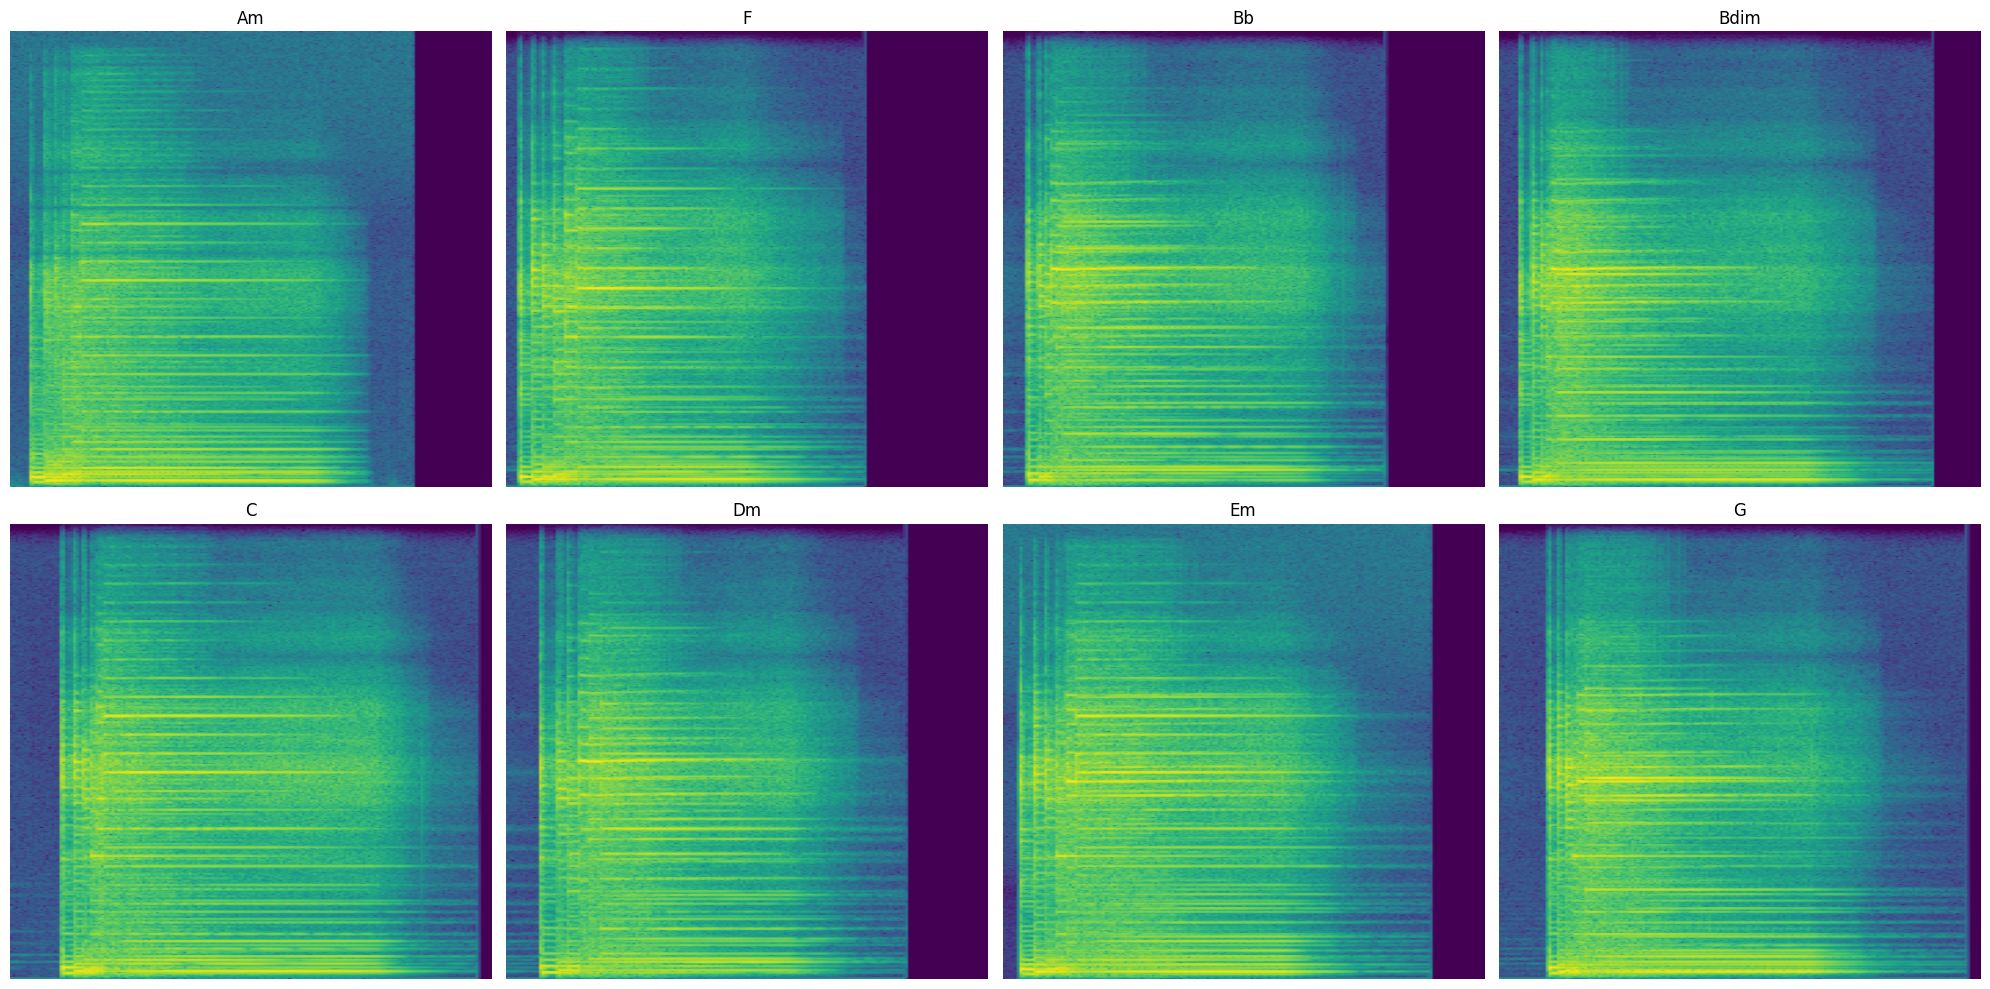

In [11]:
chords = ["Am", "F", "Bb", "Bdim", "C", "Dm", "Em", "G"]
num_chords = len(chords)

plt.figure(figsize=(20, 10))

for i, chord_label in enumerate(chords):
    for file_path, label in train_data:
        if label.numpy() == i:
            spectrogram, _ = preprocess(file_path, label)
            break

    plt.subplot(2, 4, i+1)
    plt.imshow(tf.transpose(spectrogram)[0], aspect='auto', origin='lower')
    plt.title(chord_label, fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()

### Przygotowanie *pipeline'u* treningowego
Poniżej tworzymy potok danych dla zbioru treningowego:
1. **Mapowanie funkcji `preprocess`** - każda ścieżka do pliku audio jest zamieniana na spektogram wraz z odpowiadającą mu etykietą akordu.
2. **`shuffle(1000)`** - mieszamy dane, aby kolejność próbek nie wpływała na uczenie modelu.
3. **`batch()16`** - dzielimy dane na grupy po 16 próbek, które są przetwarzane razem w jednej iteracji sieci. Wielkość *batcha* została wybrana eksperymentalnie.
4. **`prefetch(8)`** - przygotowanie kolejnych 8 *batchy* w tle, podczas gdy GPU trenuje na bieżącym *batchu*, co zwiększa wydajność uczenia.

In [12]:
# przygotowanie pipeline do trenowania modelu
trainData = train_data.map(preprocess)
trainData = trainData.shuffle(1000)
trainData = trainData.batch(16)
trainData = trainData.prefetch(8)

### Przygotowanie *pipeline'u* testowego
Analogicznie jak w przypadku *pipline'u* treningowego, z tą różnicą, że dane nie są mieszane, aby zachować spójną kolejność próbek podczas oceny wydajności modelu.

In [13]:
testData = test_data.map(preprocess)
testData = testData.batch(16)
testData = testData.prefetch(8)

### Testowanie *batchy* w *pipelinie* treningowym
Poniżej sprawdzamy, czy podział danych na *batch'e* działa poprawnie:
- `train = trainData.take(16)` - pobieramy pierwsze 16 *batchy* z *pipelin'u* treningowego,
- `train.as_numpy_iterator().next()` - konwertujemy *batch* na tablice NumPy i pobieramy pierwszy *batch*,
- `sample.shape` - sprawdzamy kształt tensora spektogramów w *batchu*, aby upewnić się, że ma oczekiwany wymiar `batch_size, czas, częstotliwość, kanał`.

Dzięki temu możemy zweryfikować, czy *pipeline* poprawnie przygotowuje dane do wejścia w model CNN.

In [14]:
train = trainData.take(16)
sample, labels = train.as_numpy_iterator().next()  
sample.shape

(16, 175, 513, 1)

### Architektura modelu konwolucyjnej sieci neuronowej (CNN)
Zdefiniowano model stanowiący konwolucyjną sieć neuronową (CNN) przeznaczoną do klasyfikacji akordów muzycznych na podstawie ich reprezentacji czasowo-częstotliwościowej w postaci spektogramów.
Na wejściu modelu znajdują się spektogramy o zmiennych wymiarach czasowych i częstotliwościowych, z pojedynczym kanałem. Odpowiada to jednowymiarowemu sygnałowi audio w postaci mono, przekształconemu do dwuwymiarowej mapy cech opisującej rozkład energii sygnału w czasie i częstotliwości.
Reprezentacja wejściowa ma postać:
$$
\text{spektrogram} = {(czas \times częstotliwość \times 1)}
$$

Konwolucyjna sieć neuronowa umożliwia automatyczne uczenie się istotnych cech ze spektrogramów sygnałów audio. Warstwy konwolucyjne służą do ekstrakcji lokalnych wzorców czasowo-częstotliwościowych charakterystycznych dla poszczególnych akordów. W modelu zastosowano dwie warsty konwolucyjne:
1. Pierwsza warstwa uczy się prostych cech, takich jak lokalne zmiany energii w określonych pasmach częstotliwości,
2. Druga warstwa uczy się bardziej złożonych cech powstałych z kombinacji cech wykrytych przez wcześniejszą warstwę, co umożliwia rozpoznawanie struktur charakterystycznych dla akordów.

Wartości parametrów architektury sieci, takie jak rozmiar filtrów konwolucyjnych (3×3), liczba filtrów (16 i 32) oraz rozmiar okna max-poolingu (2×2), zostały dobrane empirycznie zgodnie z powszechnie stosowanymi praktykami w projektowaniu konwolucyjnych sieci neuronowych. Parametry te stanowią kompromis pomiędzy zdolnością modelu do uczenia się złożonych reprezentacji a złożonością obliczeniową.

Ostatnia część modelu konwolucyjnego służy do klasyfikacji:
- `GlobalAveragePooling2D()` przekształca mapy cech z ostatniej warstwy konwolucyjnej w wektor cech globalnych, zachowując istotne informacje przy jednoczesnej redukcji liczby parametrów.
- `Dense(8, activation='softmax')` dokonuje klasyfikacji akordu na 8 klas, zwracając prawdopodobieństwa przynależności do każdej klasy.

Takie podejście pozwala sieci na skuteczne uczenie się globalnych wzorców w spektrogramach audio i przewidywanie klasy akordu.

In [15]:
model = Sequential([
    Input(shape=(None, None, 1)),
    
    # pierwsza warstwa
    Conv2D(16, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    # druga warstwa
    Conv2D(32, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    GlobalAveragePooling2D(),
    
    # Warstwa wyjściowa klasyfikatora.
    # 8 neuronów odpowiada liczbie klas (akordów), a funkcja softmax zamienia wyjścia na prawdopodobieństwa
    Dense(8, activation='softmax')
])

### Kompilacja modelu

In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy', # funkcja straty
    metrics=['accuracy']
)

### Trenowanie modelu

In [17]:
history = model.fit(trainData, epochs=100, validation_data=testData)

Epoch 1/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 51s 397ms/step - accuracy: 0.1222 - loss: 2.1573 - val_accuracy: 0.1219 - val_loss: 2.0918
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 48s 393ms/step - accuracy: 0.1194 - loss: 2.0932 - val_accuracy: 0.1219 - val_loss: 2.1093
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 48s 390ms/step - accuracy: 0.1458 - loss: 2.0709 - val_accuracy: 0.1375 - val_loss: 2.1104
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 48s 389ms/step - accuracy: 0.1590 - loss: 2.0632 - val_accuracy: 0.1469 - val_loss: 2.1068
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 47s 387ms/step - accuracy: 0.1924 - loss: 2.0536 - val_accuracy: 0.1469 - val_loss: 2.1042
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 48s 387ms/step - accuracy: 0.1917 - loss: 2.0461 - val_accuracy: 0.1500 - val_loss: 2.1052
Epoch 7/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 47s 386ms/step - accuracy: 0.1931 - loss: 2.0433 - val_accuracy: 0.1219 - val_loss: 2.1151
Epoch 8/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 47s 384ms/step - accuracy: 0.2000 - loss: 2.0353 - 

### Wizualizacja przebiegu uczenia
Poniżej przedstawiamy graficzną analizę procesu trenowania konwolucyjnej sieci neuronowej. Zobrazowano zmiany wartości funkcji straty (*loss*) oraz dokładności (*accuracy*) w kolejnych epokach uczenia.

Pierwszy wykres prezentuje przebieg funkcji straty dla zbioru treningowego oraz walidacyjnego. Spadek wartości *loss* w czasie oznacza, że model coraz lepiej dopasowuje się do danych. Porównanie krzywych treningowej i walidacyjnej pozwala ocenić, czy model nie ulega przeuczeniu (overfittingowi).

Drugi wykres przedstawia dokładność klasyfikacji dla zbioru treningowego i walidacyjnego. Wzrost wartości *accuracy* wskazuje na poprawę skuteczności modelu w rozpoznawaniu akordów. Zbieżność obu krzywych świadczy o prawidłowym procesie uczenia i dobrej generalizacji modelu.

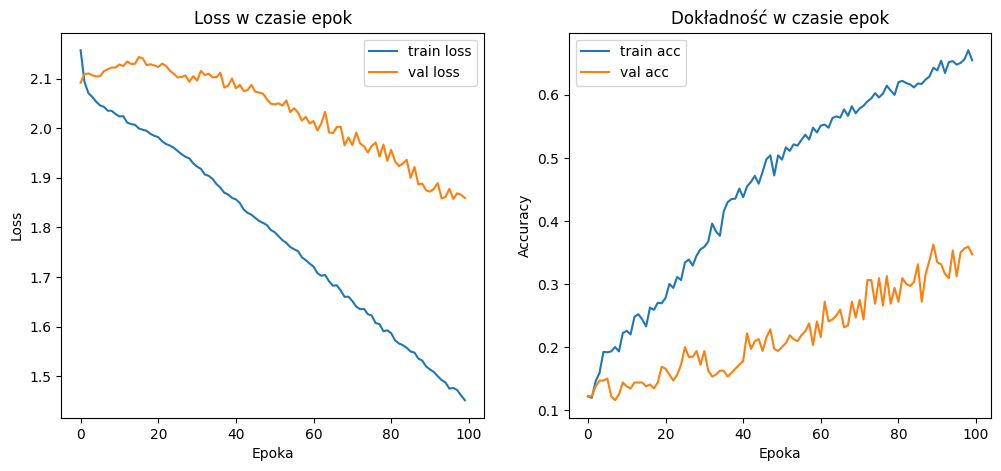

In [18]:
metrics = history.history

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], label='train loss')
plt.plot(history.epoch, metrics['val_loss'], label='val loss')
plt.title("Loss w czasie epok")
plt.xlabel("Epoka")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history.epoch, metrics['accuracy'], label='train acc')
plt.plot(history.epoch, metrics['val_accuracy'], label='val acc')
plt.title("Dokładność w czasie epok")
plt.xlabel("Epoka")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

### Macierz pomyłek

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step


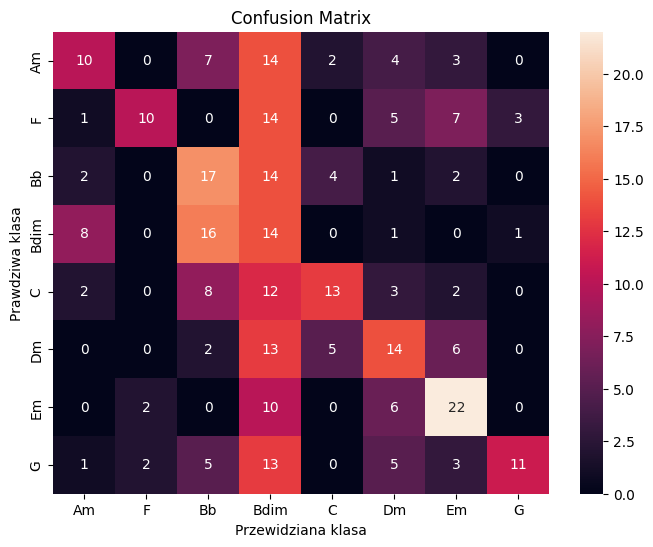

In [20]:
test_samples = []
test_labels = []

for x, y in testData:
    test_samples.append(x.numpy())
    test_labels.append(y.numpy())

test_samples = numpy.concatenate(test_samples)
test_labels = numpy.concatenate(test_labels)

y_pred = numpy.argmax(model.predict(test_samples), axis=1)
y_true = test_labels

conf_matrix = tf.math.confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=chords, yticklabels=chords)
plt.xlabel("Przewidziana klasa")
plt.ylabel("Prawdziwa klasa")
plt.title("Confusion Matrix")
plt.show()

### Predykcje modelu dla przykładowych nagrań testowych
Dla każdego akordu ze zbioru testowego wybrano pojedynczą próbkę, dla której obliczono rozkład prawdopodobieństw klas zwracany przez model. Wizualizacja umożliwia ocenę pewności predykcji oraz podobieństw pomiędzy klasami akordów.

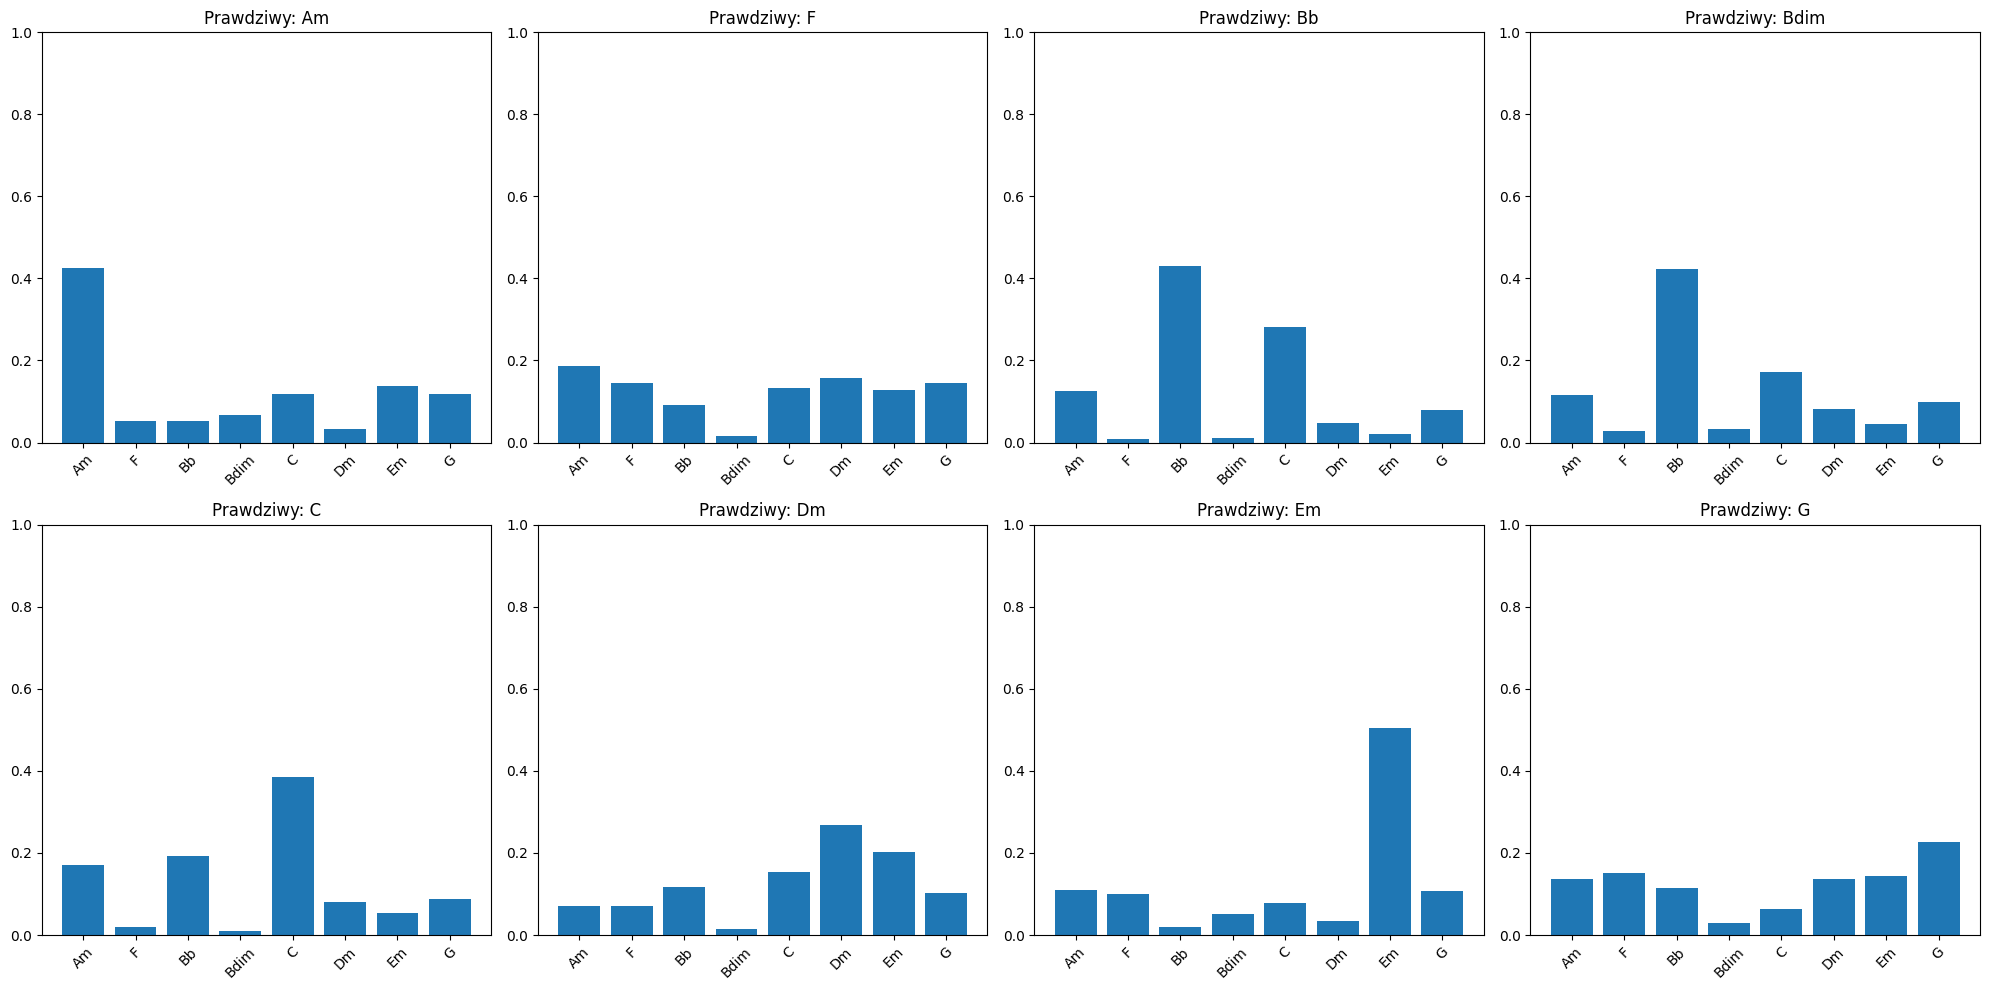

In [24]:
plt.figure(figsize=(20, 10))

used_labels = set()
plot_idx = 1

for spectrograms, labels in testData:
    for i in range(spectrograms.shape[0]):
        lbl = int(labels[i].numpy())

        if lbl in used_labels:
            continue

        spec = tf.expand_dims(spectrograms[i], axis=0)
        prediction = model.predict(spec, verbose=0)[0]

        plt.subplot(2, 4, plot_idx)
        plt.bar(chords, prediction)
        plt.title(f"Prawdziwy: {chords[lbl]}")
        plt.xticks(rotation=45)
        plt.ylim(0, 1)

        used_labels.add(lbl)
        plot_idx += 1

        if len(used_labels) == len(chords):
            break

    if len(used_labels) == len(chords):
        break

plt.tight_layout()
plt.show()
